# Analyse ROMY Events

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sixdegrees.sixdegrees import sixdegrees

from sixdegrees.plots.plot_backazimuth_results import plot_backazimuth_results
from sixdegrees.plots.plot_velocities import plot_velocities
from sixdegrees.plots.plot_waveform_cc import plot_waveform_cc
from sixdegrees.plots.plot_cwt_all import plot_cwt_all
from sixdegrees.plots.plot_velocity_method_comparison import plot_velocity_method_comparison
from sixdegrees.plots.plot_optimization_results import plot_optimization_results
from sixdegrees.plots.plot_velocities import plot_velocities


## Configurations

In [2]:
config = {
    # Required time window parameters
    'tbeg': "2025-12-08 14:15:00",  # Start time
    'tend': "2025-12-08 16:00:00",  # End time

    # event
    'origin_time': "2025-12-08 14:15:10",
    'magnitude': 7.5,

    # Station coordinates (required)
    'station_lon': 11.275476,  # BSPF longitude
    'station_lat': 48.162941,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.ROMY..",     # Default seed ID
    'rot_seed': ["BW.ROMY.10.BJZ", "BW.ROMY..BJU", "BW.ROMY..BJV"], # "BW.ROMY.30.BJ*",  # Rotation sensor seed ID
    'tra_seed': ["GR.FUR..BHZ", "GR.FUR..BHN", "GR.FUR..BHE"],  # Translation sensor seed ID
    
    # Data source
    'data_source': "sds",  # "fdsn" | "sds" | "mseed_file"

    # Path to SDS for rotation and translation data
    'path_to_sds_rot': "/home/andbro/freenas/romy_archive/",    # SDS path for rotation data
    'path_to_sds_tra': "/home/andbro/bay200/mseed_online/archive/",  # SDS path for translation data

    # Path to inventory of rotation and translation sensor
    'path_to_inv_rot': "/home/andbro/kilauea-data/stationxml_ringlaser/station_BW_ROMY.xml",  # Rotation station inventory
    'path_to_inv_tra': "/home/andbro/kilauea-data/stationxml_ringlaser/station_GR_FUR.xml",  # Translation station inventory
    
    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Set rotation of components
    'rotate_zne': True,

    # Rotate ROMY components
    'use_romy_zne': True,

    # Remove responses
    'tra_remove_response': True,
    'rot_remove_response': True,

    # Project information
    'project': "ROMY_Analysis",  # Project name

    # Backazimuth calculation parameters
    'baz_step': 1,               # Step size for backazimuth search in degrees
    'time_win_sec': 30,          # Window length in seconds
    'time_win_overlap': 15,  # Window overlap in seconds

    # Optional parameters
    'verbose': True,            # Print detailed information
}

Store configurations as Yaml File

In [3]:
filename = f"{config['tbeg'][:10].replace('-','')}_M{str(config['magnitude']).replace('.','')}"

sixdegrees.store_as_yaml(config, "./config/"+filename)

 -> file ./config/20251208_M75.yml already exists. Aborting...


Setup a sixdegrees object

In [4]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [5]:
# sd.store_as_pickle(config, "./event_configs/"+f"M{str(config['magnitude']).replace('.','')}_{config['tbeg'][:10].replace('-','')}")

Get key information about the event

In [6]:
try:
    ev = sd.get_event_info(
        origin_time=config['origin_time'],
        base_catalog="USGS",
        magnitude=config['magnitude'],
    )
except:
    print("No event found")
    ev = {
        "backazimuth": 0,
        "distance_km": 0,
        "origin_time": config['origin_time'],
        "magnitude": config['magnitude']
    }

Found event:
Origin time: 2025-12-08T14:15:10.394000Z
Magnitude: 7.6 mww
Location: 41.043°N, 142.141°E
Depth: 44.1 km
Epicentral Distance: 9007.33 km
Epicentral Distance: 81.0°
Backazimuth: 35.27°


This will load the data from the data source:
- local mseed file
- local sds system
- fdsn (online)

and trim it to the time window

In [7]:
sd.load_data(config['tbeg'], config['tend'], resample_rate=5)

-> fetching GR.FUR..BHZ data from SDS
-> fetching GR.FUR..BHN data from SDS
-> fetching GR.FUR..BHE data from SDS
-> translation inventory provided: /home/andbro/kilauea-data/stationxml_ringlaser/station_GR_FUR.xml
-> removing response: ACC
-> rotating translational data ZNE to ZNE
3 Trace(s) in Stream:
GR.FUR..BHZ | 2025-12-08T14:14:58.990000Z - 2025-12-08T16:00:00.990000Z | 20.0 Hz, 126041 samples
GR.FUR..BHN | 2025-12-08T14:14:58.990000Z - 2025-12-08T16:00:00.990000Z | 20.0 Hz, 126041 samples
GR.FUR..BHE | 2025-12-08T14:14:58.989999Z - 2025-12-08T16:00:00.989999Z | 20.0 Hz, 126041 samples
-> fetching BW.ROMY.10.BJZ data from SDS
-> fetching BW.ROMY..BJU data from SDS
-> fetching BW.ROMY..BJV data from SDS
-> rotation inventory provided: /home/andbro/kilauea-data/stationxml_ringlaser/station_BW_ROMY.xml
-> removing sensitivity
-> rotated ROMY data using rotate_romy_zne (keep_z=True)
3 Trace(s) in Stream:
BW.ROMY..BJZ | 2025-12-08T14:14:58.991799Z - 2025-12-08T16:00:00.991799Z | 20.0 

Ensure that all traces of stream have the same sample size

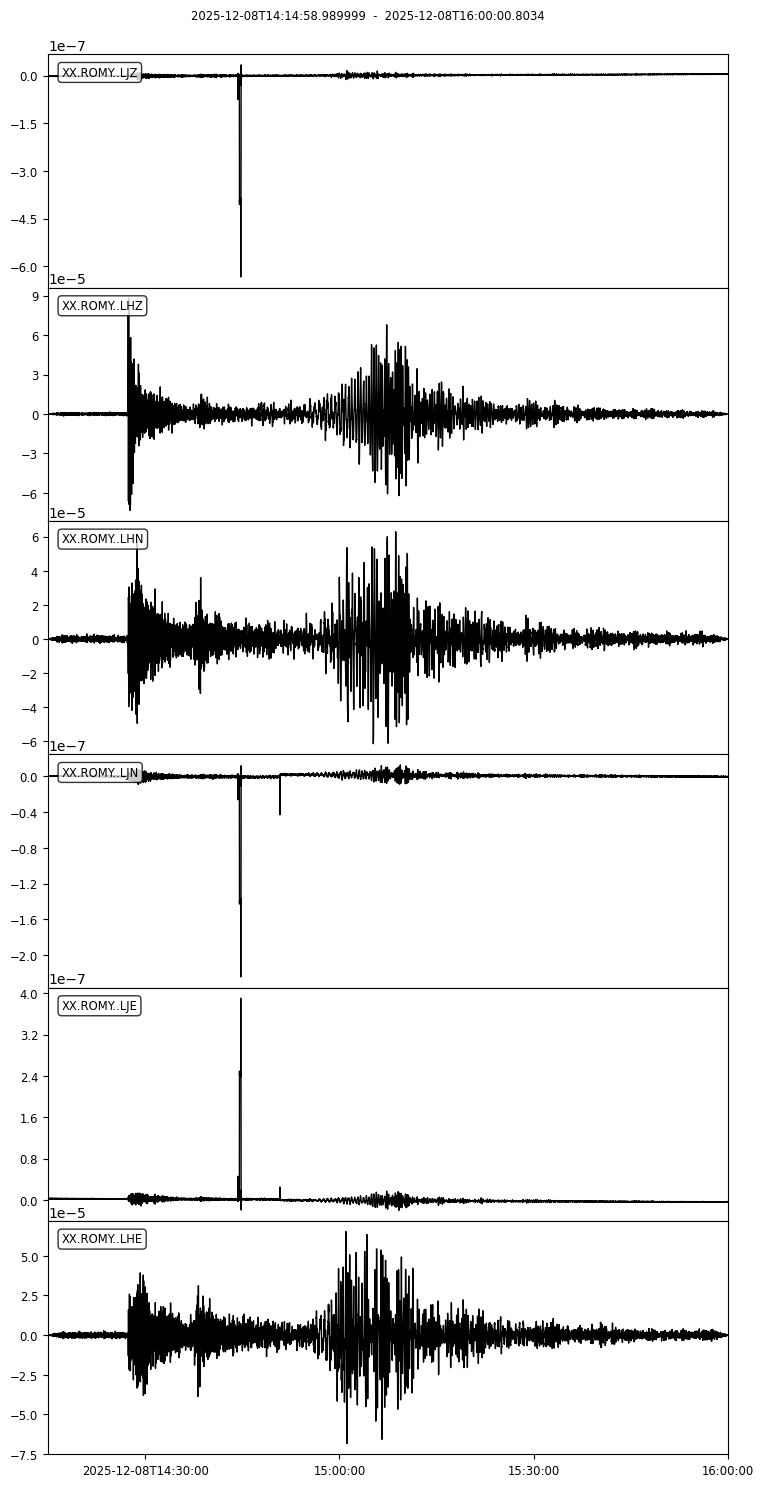

In [8]:
sd.st.plot(equal_scale=False);

In [9]:
sd.trim_stream(set_common=True, set_interpolate=False)

We have to replace the values for the distorted data with zeros to allow usfuly further processing.

In [10]:
sd.replace_values_in_window(tbeg=sd.tbeg+1600, tend=sd.tbeg+2000, value=0, channel_list=["JZ", "JN", "JE"])

  -> Replaced 2001 samples in XX.ROMY..LJZ from 2025-12-08T14:41:40.000000Z to 2025-12-08T14:48:20.000000Z with value 0
  -> Replaced 2001 samples in XX.ROMY..LJN from 2025-12-08T14:41:40.000000Z to 2025-12-08T14:48:20.000000Z with value 0
  -> Replaced 2001 samples in XX.ROMY..LJE from 2025-12-08T14:41:40.000000Z to 2025-12-08T14:48:20.000000Z with value 0
  -> Modified 3 trace(s): ['XX.ROMY..LJZ', 'XX.ROMY..LJN', 'XX.ROMY..LJE']


In [11]:
sd.st = sd.st.trim(sd.tbeg+500, sd.tend-2500)

### Write data to file or SDS system

In [12]:
# write to mseed file
# sd.st.write(f"./data/romy_eventM{config['magnitude']}.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

### Wavelet Comparsion

In [13]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:

    try:
        # Rotation components
        rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
        cwt_results[f"{comp}_Rotation"] = sd.compute_cwt(
            rot_data.times(),
            rot_data.data,
            rot_data.stats.delta,
            normalize=True,
            fmin=0.01,
            fmax=1.0
        )
    except:
        print(f"No {comp} data for rotation")
    try:
        # Translation components
        acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
        cwt_results[f"{comp}_Translation"] = sd.compute_cwt(
            acc_data.times(),
            acc_data.data,
            acc_data.stats.delta,
            normalize=True,
            fmin=0.01,
            fmax=1.0
        )
    except:
        print(f"No {comp} data for ranslation")


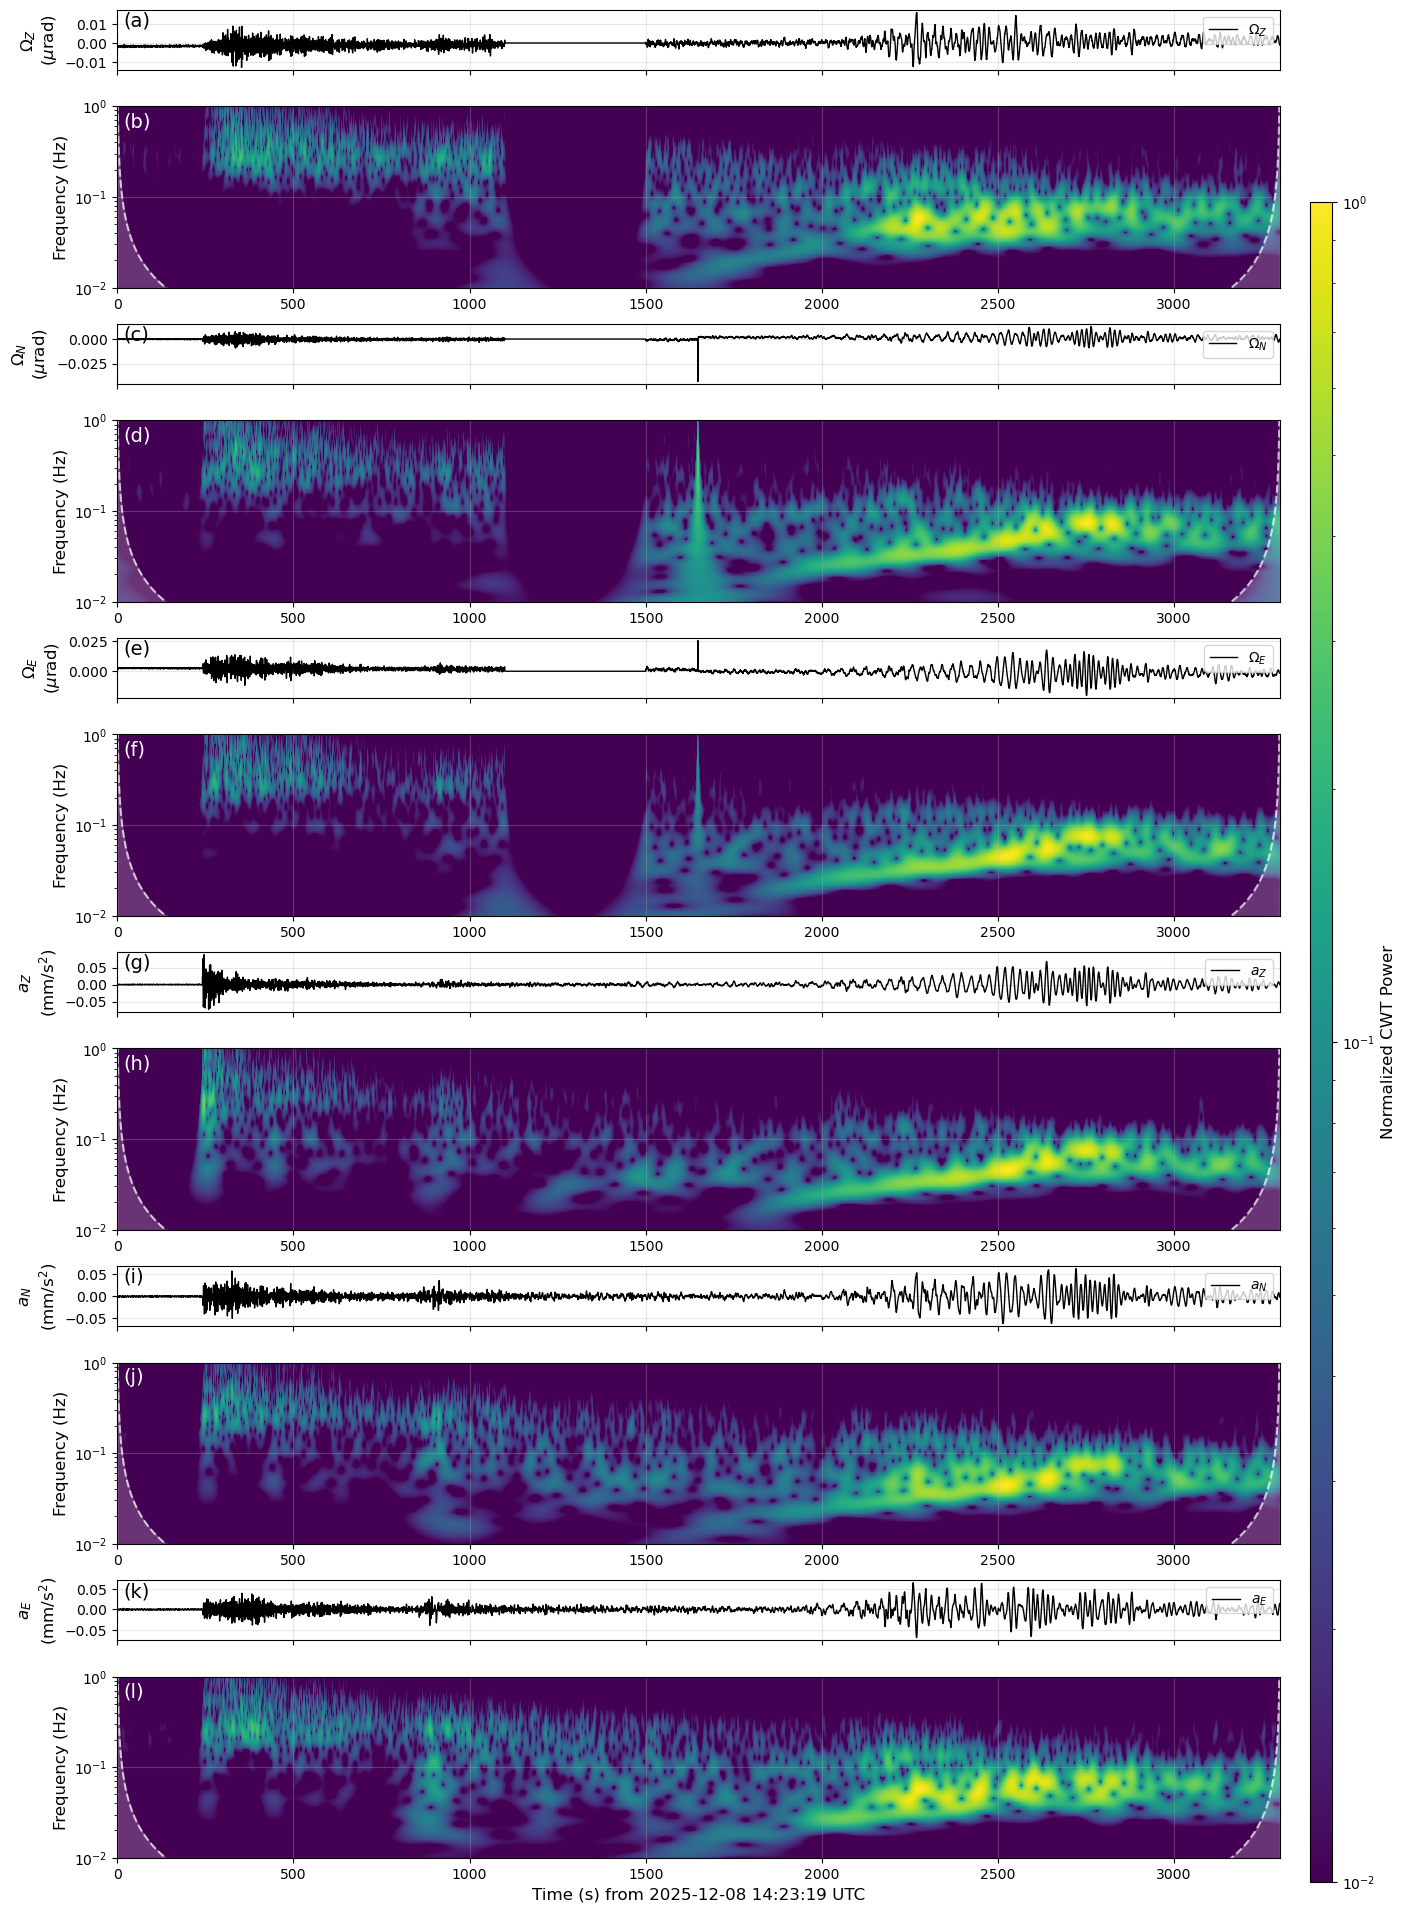

In [14]:
# Then plot all components
fig = plot_cwt_all(
    rot=sd.get_stream("rotation"),
    acc=sd.get_stream("translation"),
    cwt_output=cwt_results,
    clog=True,
    fmin=0.01,
    fmax=1
)

del fig

### Processing

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [15]:
sd.filter_data(fmin=0.01, fmax=0.1, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [16]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=True)

-> polarity for channel HZ changed from 1 to -1


let's compare the waveforms of the rotation (red) and translational (black) components 

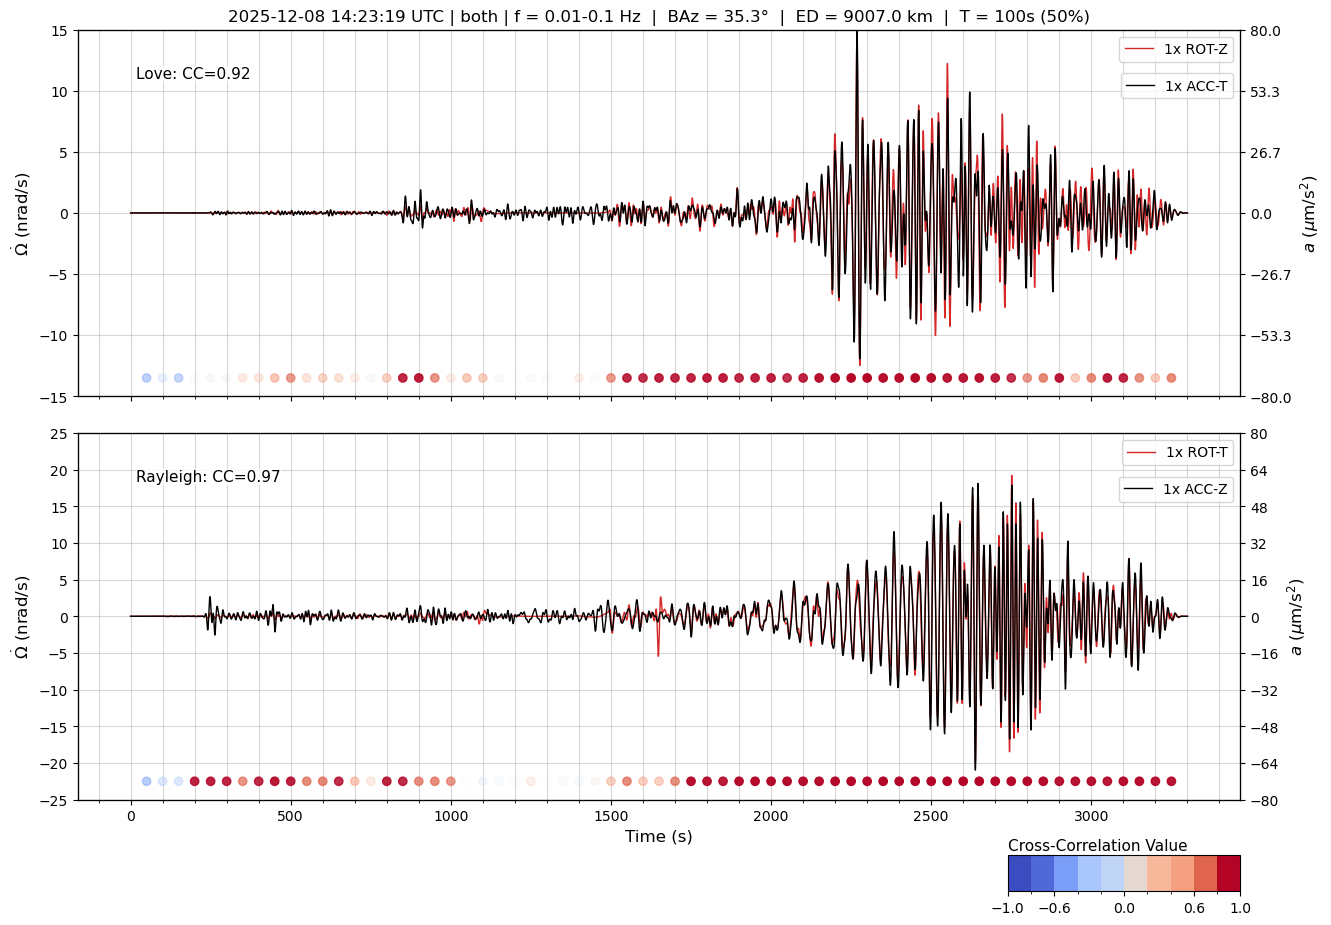

In [17]:
fig = plot_waveform_cc(
    rot0=sd.get_stream("rotation"),
    acc0=sd.get_stream("translation"),
    baz=ev['backazimuth'],
    distance=ev['distance_km'],
    fmin=sd.fmin,
    fmax=sd.fmax,
    twin_sec=100,
    twin_overlap=0.5,
    wave_type="both",
)

Check by cross-correlation if there is any time delay (e.g. due to timeing errors)

In [18]:
#finde (and correct) time lag between translation and rotation data
sd.get_component_lag(
    normalize=True,
    baz=ev['backazimuth'],
    correct=False
)

ROT-T & ACC-Z:  lag_time: 0.2 s, lag_samples: 1, cc_max: 0.98
ROT-Z & ACC-T:  lag_time: 0.4 s, lag_samples: 2, cc_max: 0.92


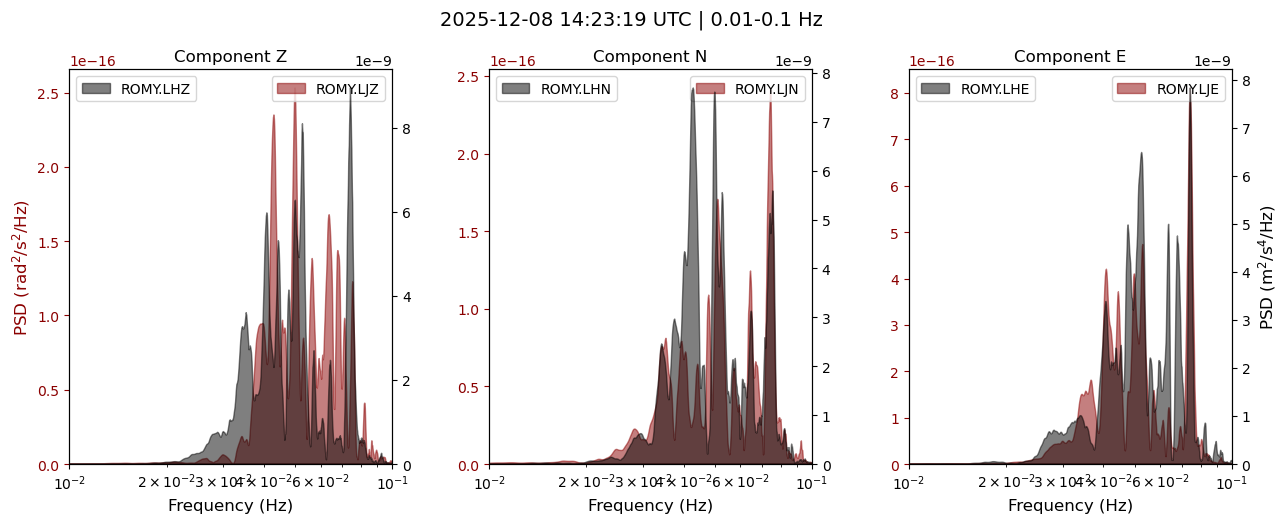

In [19]:
fig = sd.plot_spectra_comparison_fill(
    rot=sd.get_stream("rotation"), 
    acc=sd.get_stream("translation"),
    fmin=sd.fmin, fmax=sd.fmax,
    ylog=False, xlog=True, fill=True
)

### Backazimuth Estimate

baz_max = 50, baz_std = 27


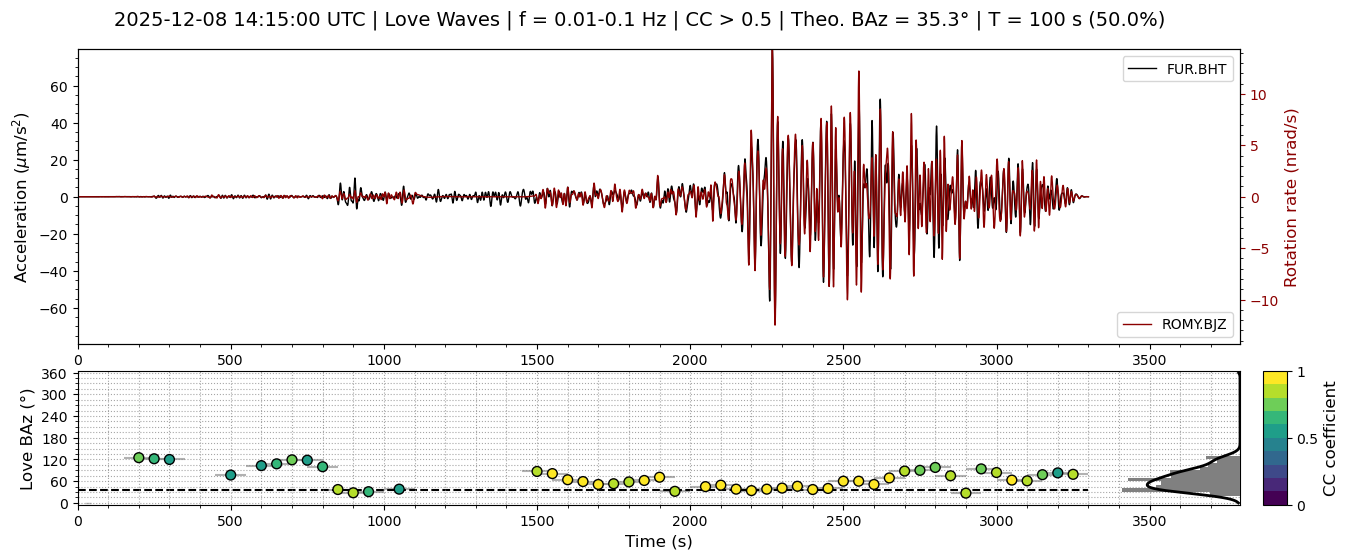

In [20]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=1,
    baz_win_sec=100,
    baz_win_overlap=0.5,
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5  # optional
)

baz_max = 31, baz_std = 6


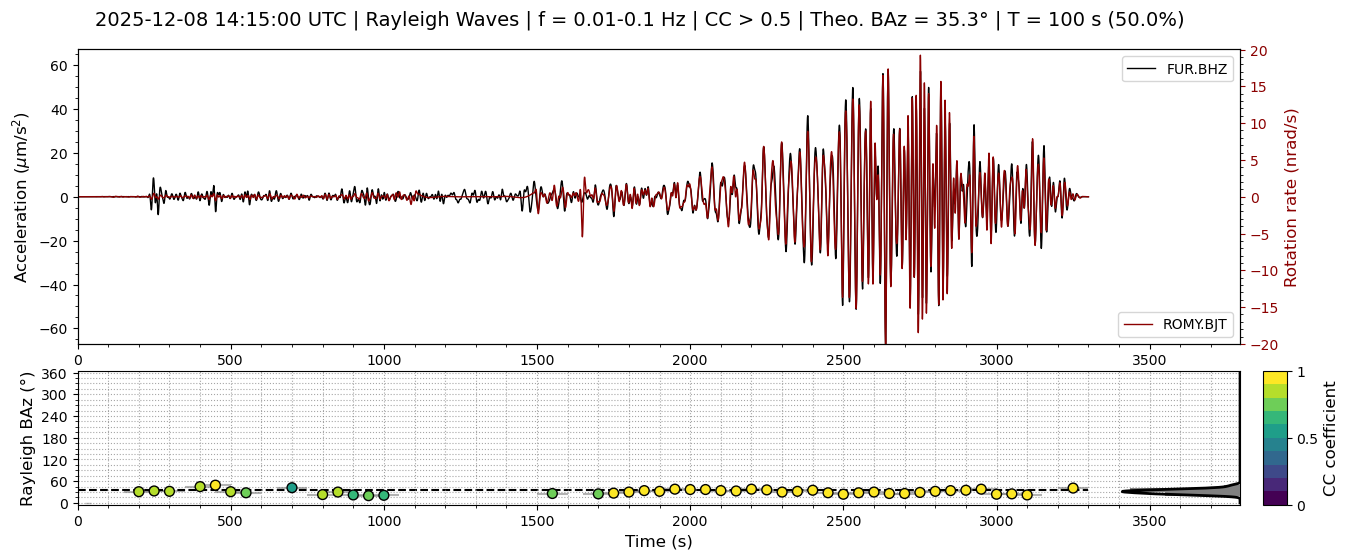

In [21]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=1,
    baz_win_sec=100,
    baz_win_overlap=0.5,
    out=True
)

# Then plot results
fig = plot_backazimuth_results(
    sd,
    baz_results,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5  # optional
)

Using precomputed love backazimuth results

Estimated BAZ Love = 54° (CC ≥ 0.5)
Using precomputed rayleigh backazimuth results

Estimated BAZ Rayleigh = 41° (CC ≥ 0.5)
Computing tangent wave backazimuth...

Estimated BAZ Tangent = 31° (CC ≥ 0.5)


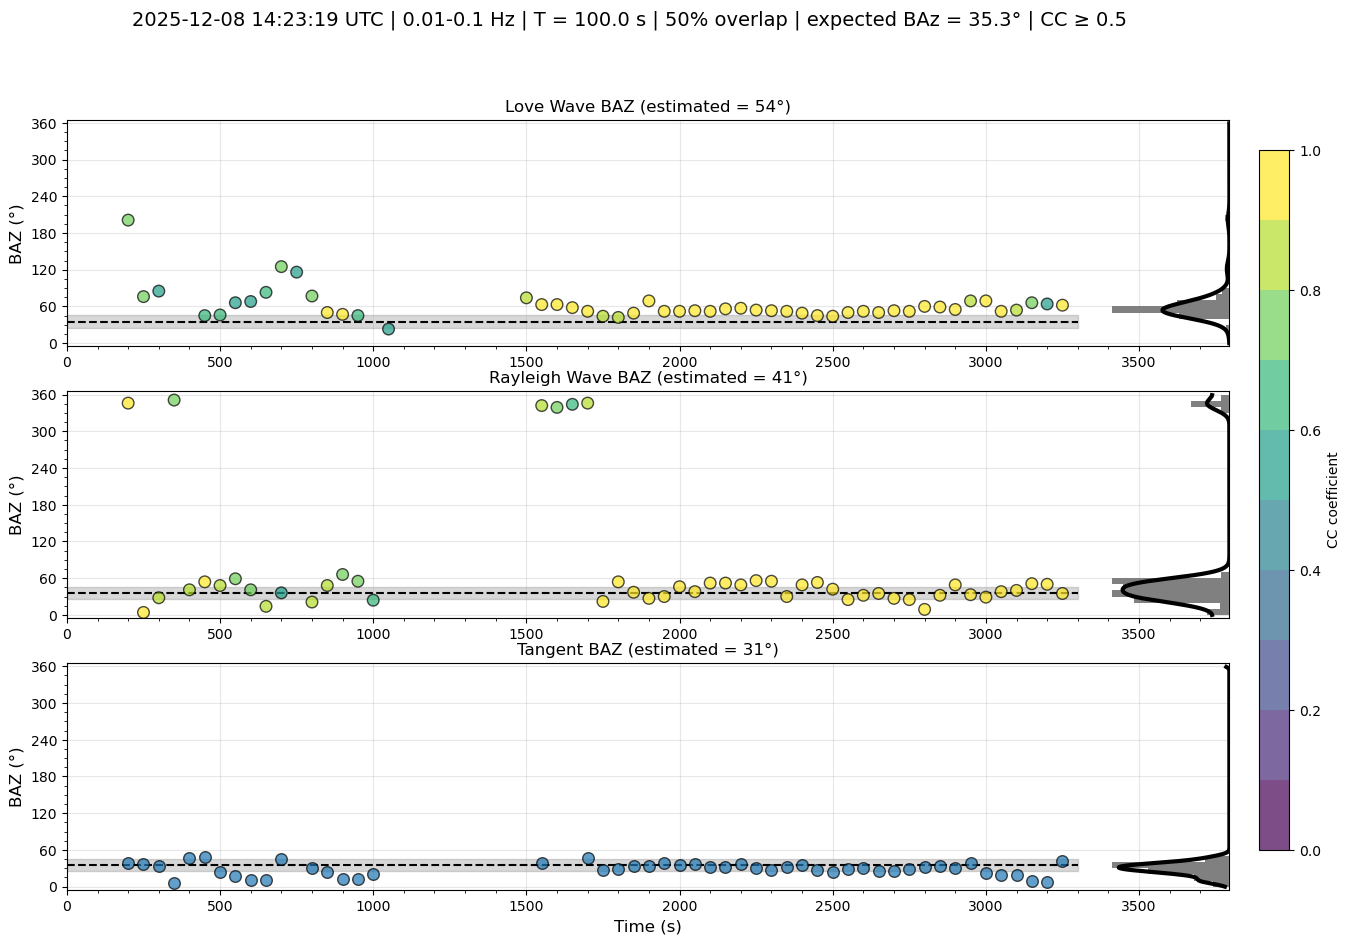

In [22]:
fig, results = sd.compare_backazimuth_methods(
    Twin=100.0,
    Toverlap=0.5,
    cc_threshold=0.5,
    baz_theo=ev['backazimuth'],
    plot=True,
    output=True
)

### Analyse phase velocities

In [23]:
# parameters
twin = 200
overlap = 0.5
cc_threshold = 0.8


Using event BAZ 35.27


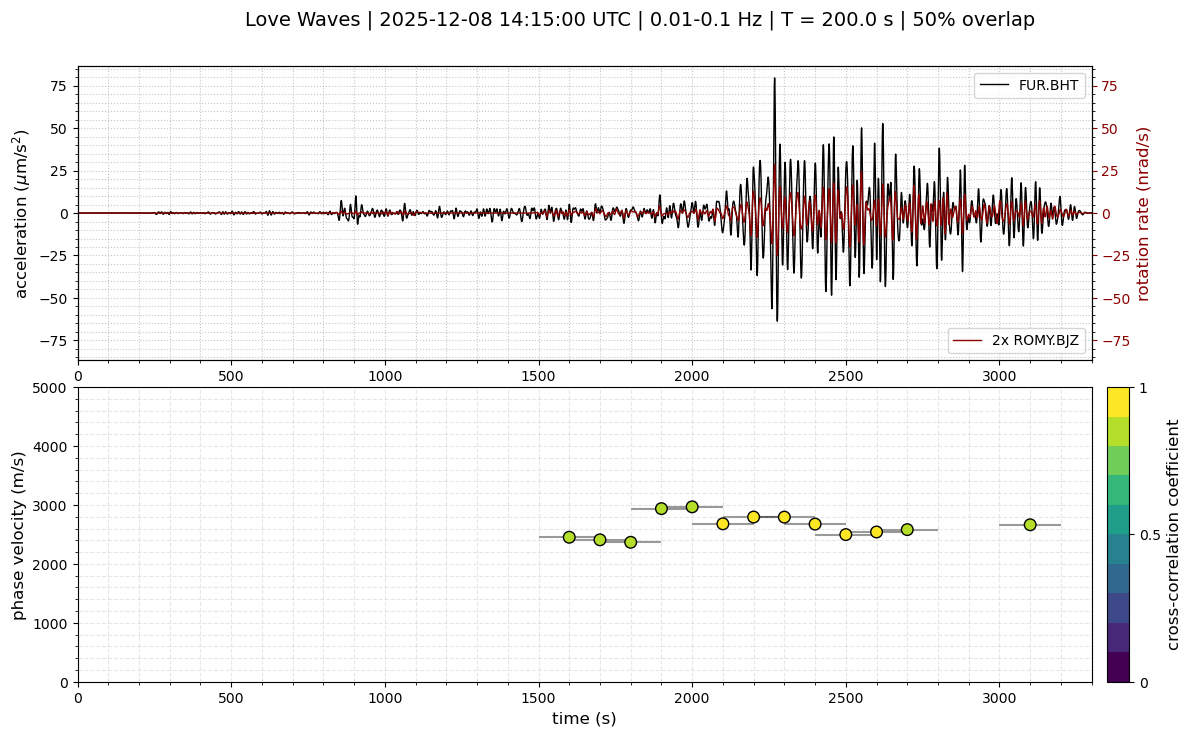

In [24]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=twin,
    overlap=overlap,
    cc_threshold=cc_threshold,
    method='odr',
)

# Plot results
fig = plot_velocities(sd,
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)


Using event BAZ 35.27


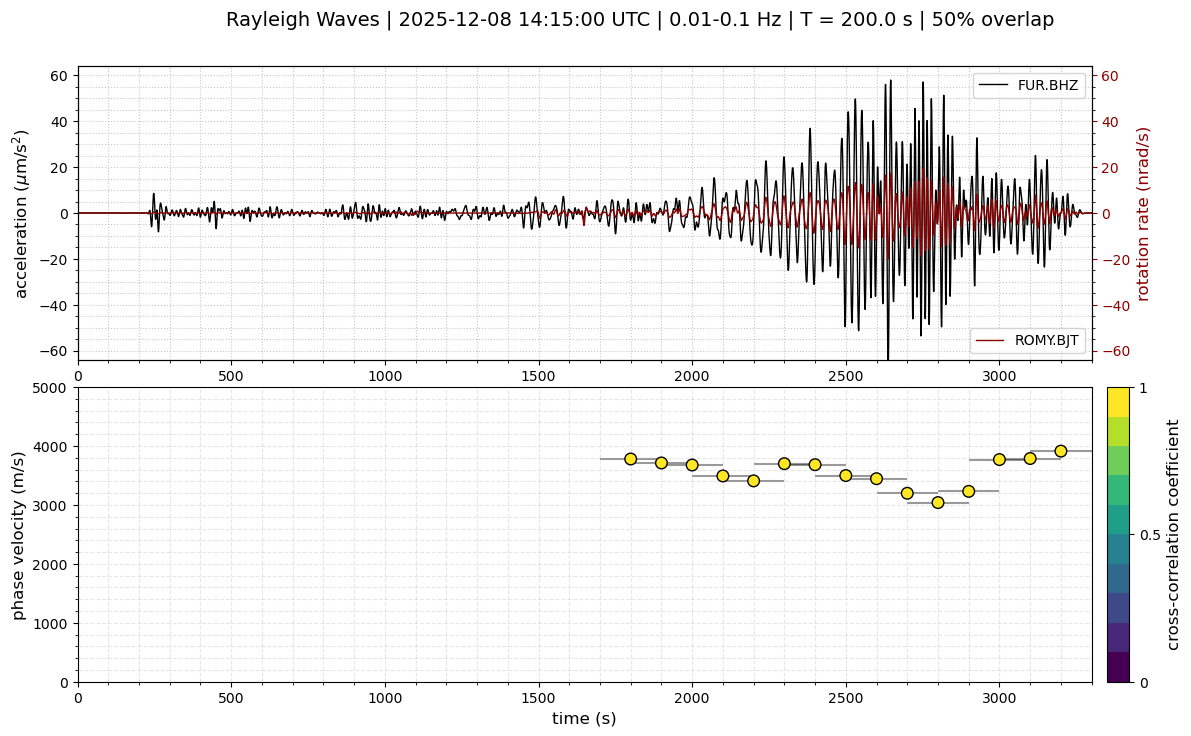

In [25]:
# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=twin,
    overlap=overlap,
    cc_threshold=cc_threshold,
    method='odr',
)

# Plot results
fig = plot_velocities(sd,
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

In [26]:
# Compute velocities using envelopes for Love waves
love_velocities_env = sd.compute_velocities_envelope(
    wave_type='love',
    win_time_s=twin,
    overlap=overlap,
    cc_threshold=cc_threshold,
    method='odr',
)

# Plot results
fig = plot_velocities(sd,
    velocity_results=love_velocities_env,
    vmax=5000,  # optional
    minors=True # optional
)

ValueError: No backazimuth provided or available

In [ ]:
# Compute velocities using envelopes for Love waves
rayleigh_velocities_env = sd.compute_velocities_envelope(
    wave_type='rayleigh',
    win_time_s=twin,
    overlap=overlap,
    cc_threshold=cc_threshold,
    method='odr',
)

# Plot results
fig = plot_velocities(sd,
    velocity_results=rayleigh_velocities_env,
    vmax=5000,  # optional
    minors=True # optional
)

In [ ]:
def plot_velocity_comparison(vel_results, vel_results_env, cc_threshold=0.8, vmax=5000):
    """
    Simple function to plot phase velocities from standard and envelope methods.
    
    Parameters:
    -----------
    vel_results : dict
        Velocity results dictionary from compute_velocities
    vel_results_env : dict
        Velocity results dictionary from compute_velocities_envelope
    cc_threshold : float
        Minimum cross-correlation coefficient threshold (default: 0.5)
    vmax : float
        Maximum velocity for y-axis limit (default: 5000)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Create masks based on cc_threshold
    mask1 = vel_results['ccoef'] >= cc_threshold
    mask2 = vel_results_env['ccoef'] >= cc_threshold
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot standard velocities
    ax.scatter(vel_results['time'][mask1], 
               vel_results['velocity'][mask1],
               c=vel_results['ccoef'][mask1],
               cmap='viridis', s=50, alpha=0.7,
               edgecolors='black', linewidth=0.5,
               label='Standard method',
               vmin=cc_threshold, vmax=1.0,
               zorder=2)
    
    # Plot envelope velocities
    ax.scatter(vel_results_env['time'][mask2],
               vel_results_env['velocity'][mask2],
               c=vel_results_env['ccoef'][mask2],
               cmap='plasma', s=50, alpha=0.7,
               edgecolors='red', linewidth=0.5,
               marker='s',  # square markers to distinguish
               label='Envelope method',
               vmin=cc_threshold, vmax=1.0,
               zorder=2)
    
    # Add error bars for standard method
    ax.errorbar(vel_results['time'][mask1],
                vel_results['velocity'][mask1],
                xerr=vel_results['terr'][mask1],
                fmt='none', color='black', alpha=0.3,
                zorder=1)
    
    # Add error bars for envelope method
    ax.errorbar(vel_results_env['time'][mask2],
                vel_results_env['velocity'][mask2],
                xerr=vel_results_env['terr'][mask2],
                fmt='none', color='red', alpha=0.3,
                zorder=1)
    
    # Customize plot
    ax.set_xlabel('Time (s)', fontsize=12)
    ax.set_ylabel('Phase Velocity (m/s)', fontsize=12)
    ax.set_ylim(bottom=0, top=vmax)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper right', fontsize=11)
    
    # Add title with parameters
    wave_type = vel_results['parameters']['wave_type'].capitalize()
    title = f"{wave_type} Wave Phase Velocities Comparison"
    title += f" (cc ≥ {cc_threshold})"
    ax.set_title(title, fontsize=13, fontweight='bold')
    
    # Add statistics text
    if np.any(mask1):
        mean1 = np.nanmean(vel_results['velocity'][mask1])
        std1 = np.nanstd(vel_results['velocity'][mask1])
        stats1 = f"Standard: {mean1:.1f} ± {std1:.1f} m/s"
    else:
        stats1 = "Standard: No data"
    
    if np.any(mask2):
        mean2 = np.nanmean(vel_results_env['velocity'][mask2])
        std2 = np.nanstd(vel_results_env['velocity'][mask2])
        stats2 = f"Envelope: {mean2:.1f} ± {std2:.1f} m/s"
    else:
        stats2 = "Envelope: No data"
    
    ax.text(0.02, 0.98, f"{stats1}\n{stats2}",
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            fontsize=10)
    
    plt.tight_layout()
    return fig

# Plot comparison
fig = plot_velocity_comparison(rayleigh_velocities, rayleigh_velocities_env, 
                                cc_threshold=0.8, vmax=5000)

fig = plot_velocity_comparison(love_velocities, love_velocities_env, 
                                cc_threshold=0.8, vmax=5000)


### Compare RANSAC and ODR Method

In [ ]:
# Compute Love wave velocities
love_velocities_ransac = sd.compute_velocities(
    wave_type='love',
    win_time_s=twin,
    overlap=overlap,
    cc_threshold=cc_threshold,
    method='ransac',
    baz=ev['backazimuth']  # optional
)

# Compute Love wave velocities
love_velocities_odr = sd.compute_velocities(
    wave_type='love',
    win_time_s=twin,
    overlap=overlap,
    cc_threshold=cc_threshold,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities_ransac = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=twin,
    overlap=overlap,
    cc_threshold=cc_threshold,
    method='ransac',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities_odr = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=twin,
    overlap=overlap,
    cc_threshold=cc_threshold,
    method='odr',
    baz=ev['backazimuth']  # optional
)

In [ ]:
from sixdegrees.plots.plot_velocity_method_comparison import plot_velocity_method_comparison

fig = plot_velocity_method_comparison(
    rayleigh_velocities_odr,
    rayleigh_velocities_ransac,
    vel_max=5000,
    cc_threshold=0.5,
    labels=('ODR', 'RANSAC')
)

fig = plot_velocity_method_comparison(
    love_velocities_odr,
    love_velocities_ransac,
    vel_max=5000,
    cc_threshold=0.5,
    labels=('ODR', 'RANSAC')
)

In [ ]:
# Compute Love wave velocities with adaptive/optimzed backazimuths per window
love_velocities_optimized = sd.compute_velocities_optimized(
    rotation_data=sd.get_stream("rotation", raw=True),
    translation_data=sd.get_stream("translation", raw=True),
    wave_type='love',
    baz_results=baz_results,
    baz_mode='max',
    method='odr',
    cc_threshold=0.0,
    r_squared_threshold=0.0,
    zero_intercept=True
)

love_velocities_optimized['parameters']['baz'] = ev['backazimuth']

In [ ]:
fig = plot_velocities(
    sd,
    velocity_results=love_velocities_optimized,
    vmax=6000,  # optional
    minors=True, # optional
    cc_threshold=0.7,
)